### iSIM-sigma applied to clustering

In this notebook we show one of the potential applications of iSIM-sigma. Since we are mesuring the stardad deviation of the similarites of a set, we can use this as metric of the compactness of a cluster. 

In this notebook, we will use the novel BitBIRCH algorithm to cluster one of the databases, and we will evaluate the average similarity of each cluster with iSIM, and the compactness with iSIM-sigma.

In [1]:
import bitbirch.bitbirch as bb
from isim_sigma.isim import calculate_isim
from isim_sigma.sigma import stratified_sigma
from bitbirch.plotting_utils import init_plot, save_metrics_to_csv, mol_visualization
import numpy as np
import pandas as pd

In this example we will compare the clustering of MACCS fingerprints and ECFP4 fingerprints, and how the use of iSIM and iSIM-sigma can give equivalent/similar clustering when used to determine the threshold.

MACCS

In [5]:
fps_maccs = np.load('maccs/CHEMBL204_Ki_fp.npy', mmap_mode='r')
fps_maccs = fps_maccs.astype(np.int64)

In [7]:
std = stratified_sigma(fps_maccs, n=50, n_ary = "JT")
isim = calculate_isim(fps_maccs, n_ary="JT")

print(f"iSIM: {isim}")
print(f"iSIM-{chr(963)}: {std}")

print(f"iSIM + 1.96 * {chr(963)}: {isim + 1.96 * std}")

iSIM: 0.48387059285373524
iSIM-σ: 0.12093957359570517
iSIM + 1.96 * σ: 0.7209121571013174


ECFP4

In [12]:
fps_ecfp4 = np.load('ecfp4/CHEMBL204_Ki_fp.npy', mmap_mode='r')
fps_ecfp4 = fps_ecfp4.astype(np.int64)

In [13]:
std = stratified_sigma(fps_ecfp4, n=50, n_ary = "JT")
isim = calculate_isim(fps_ecfp4, n_ary="JT")

print(f"iSIM: {isim}")
print(f"iSIM-{chr(963)}: {std}")

print(f"iSIM + 1.96 * {chr(963)}: {isim + 1.96 * std}")

iSIM: 0.170095315473996
iSIM-σ: 0.07230247655403
iSIM + 1.96 * σ: 0.3118081695198948


In this case, we can notice that the average and the variance of the similarities is significantly different with the type of fingeprint. If we assume that the similarity distribution is close to normality, we can use 1.96 to multiply the standard deviation to get the value of the molecules in top 5th percentile according to similarity. In this way, we can warranty that the clustering will be done with equivalent thresholds across different types of fingeprints.

In [35]:
# Define population plot
import matplotlib.pyplot as plt
def population_plot(clustered_ids, top_clusters=20, name='Population'):
    # Sort BFs by size
    clustered_ids = sorted(clustered_ids, key=lambda x: len(x), reverse=True)

    # Get the BFs of interest
    mol_indices = clustered_ids[:top_clusters]

    # Plot the population
    plt.figure(figsize=(10, 5))
    plt.bar(range(top_clusters), [len(x) for x in mol_indices], color = 'blue', label='Population')

    # Anotate the number of molecules in each cluster above the bars
    for i, mol in enumerate(mol_indices):
        plt.text(i, len(mol), len(mol), ha='center', va='bottom')

    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Number of molecules', fontsize=14)

    plt.xticks(range(top_clusters), rotation=45)

    plt.savefig(f'{name}.png', dpi=300, bbox_inches='tight')
    plt.show()

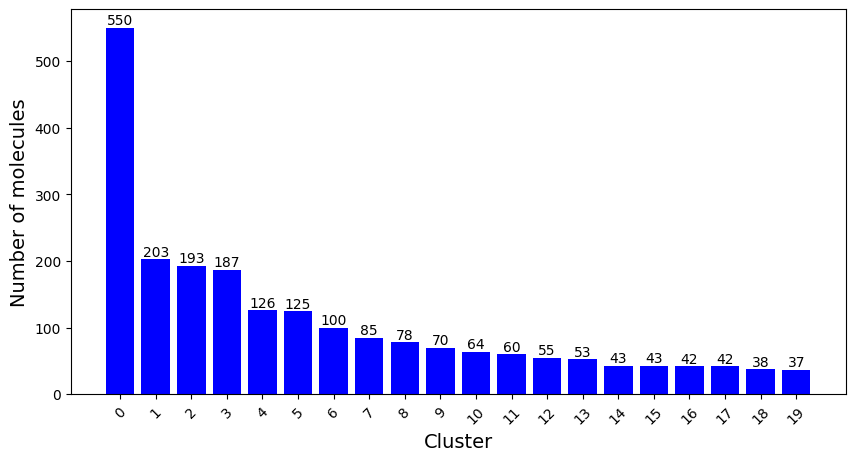

In [36]:
# MACCS using standard 0.65 threshold
bb.set_merge("diameter")
brc_maccs = bb.BitBirch(threshold=0.65, branching_factor=50)
brc_maccs.fit(fps_maccs)

population_plot(brc_maccs.get_cluster_mol_ids(), top_clusters=20, name='figures/MACCS_0.65')


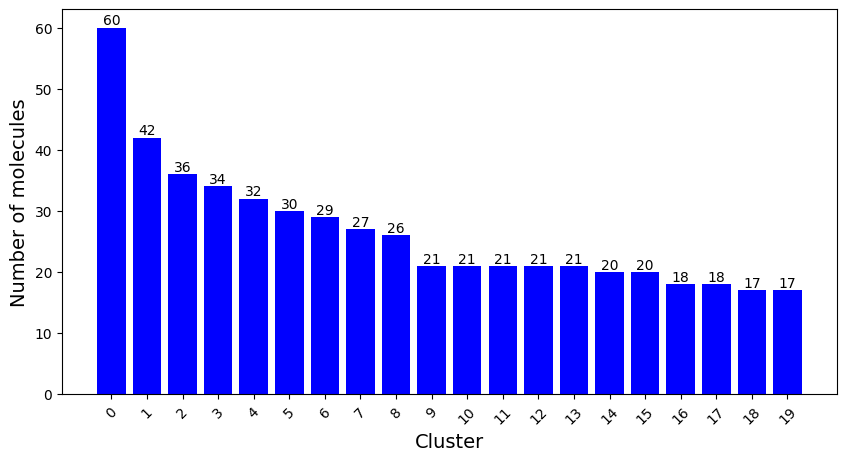

In [37]:
# ECFP4 using standard 0.65 threshold
bb.set_merge("diameter")
brc_ecfp4 = bb.BitBirch(threshold=0.65, branching_factor=50)
brc_ecfp4.fit(fps_ecfp4)

population_plot(brc_ecfp4.get_cluster_mol_ids(), top_clusters=20, name='figures/ECFP4_0.65')

We can clearly notice how the populations of clusters are really different when we use a threshold without any information from the average and variance of the similarity distribution.

Now, we will use the values we calculated above as thresholds to see if we obtain equivalent cluster populations.

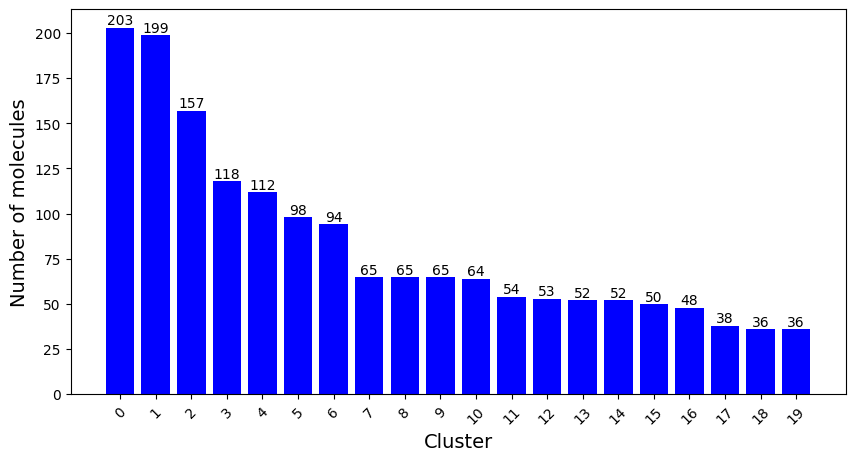

In [38]:
# MACCS using standard 0.72 (iSIM + 1.96 * iSIM-sigma) threshold
bb.set_merge("diameter")
brc_maccs = bb.BitBirch(threshold=0.72, branching_factor=50)
brc_maccs.fit(fps_maccs)

population_plot(brc_maccs.get_cluster_mol_ids(), top_clusters=20, name='figures/MACCS_0.72')

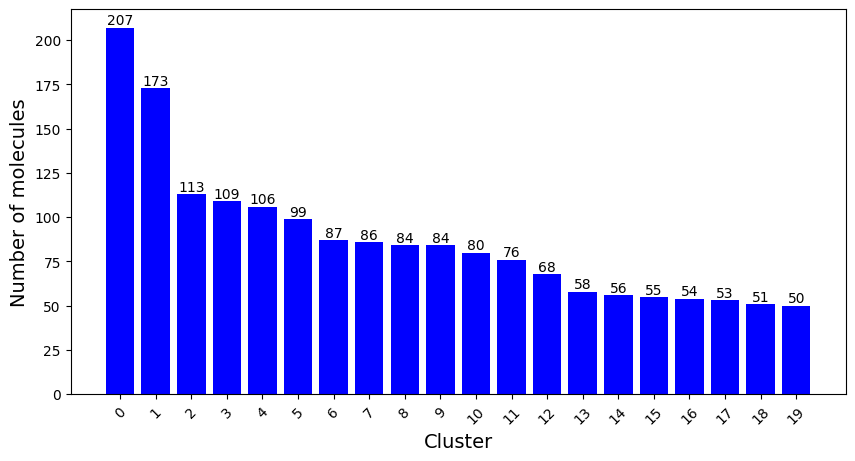

In [41]:
# ECFP4 using 0.31 (iSIM + 1.96 * iSIM-sigma) threshold
bb.set_merge("diameter")
brc_ecfp4 = bb.BitBirch(threshold=0.31, branching_factor=50)
brc_ecfp4.fit(fps_ecfp4)

population_plot(brc_ecfp4.get_cluster_mol_ids(), top_clusters=20, name='figures/ECFP4_0.31')

We can see now that the clustering populations are way similar between types of fingerprints.